### Imports

In [62]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Layer, Dropout

warnings.filterwarnings('ignore')

### Data collection and cleaning

In [63]:
df = pd.read_csv("/kaggle/input/english-to-hindi-parallel-dataset/newdata.csv")

In [64]:
df.sample(5)

,Unnamed: 0,english_sentence,hindi_sentence
163122,35515,For this reason Bilas Kewatin together with he...,इस कारण बिलास केवातिन ने अपने पति के साथ मिलकर...
84546,84546,Geetha gives a beautiful account of one lord a...,इसमें एकेश्वरवाद कर्म योग ज्ञानयोग भक्ति योग क...
55700,55700,they have to put it into boxes,उन्हे वापस बक्सो मे डालना होगा
125865,125865,Girl spoiled before ripened.,पकने से पहले नष्ट लड़की.
91385,91385,"Cookies, the web server sends data which is th...",कुकी यह वेब सर्वर द्वारा भेजा गया डेटा होता है...


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177606 entries, 0 to 177605
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        177606 non-null  int64 
 1   english_sentence  177604 non-null  object
 2   hindi_sentence    177606 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


In [66]:
df.drop(columns=['Unnamed: 0'], inplace = True)

In [67]:
df.rename(columns = {'english_sentence' : 'en', 'hindi_sentence' : 'hi'}, inplace = True)

In [68]:
df.isna().sum()

en    2
hi    0
dtype: int64

In [69]:
df.dropna(inplace = True)

In [70]:
df.duplicated().sum()

2841

In [71]:
df.drop_duplicates(inplace = True)

In [72]:
df.shape

(174763, 2)

In [73]:
df['len1'] = [len(i.split()) for i in df.en]
df['len2'] = [len(i.split()) for i in df.hi]

In [74]:
df.describe()

,len1,len2
count,174763.000000,174763.000000
mean,16.604693,18.007004
std,12.969380,14.680386
min,1.000000,1.000000
25%,8.000000,9.000000
50%,13.000000,15.000000
75%,22.000000,23.000000
max,398.000000,418.000000


### Visualizing

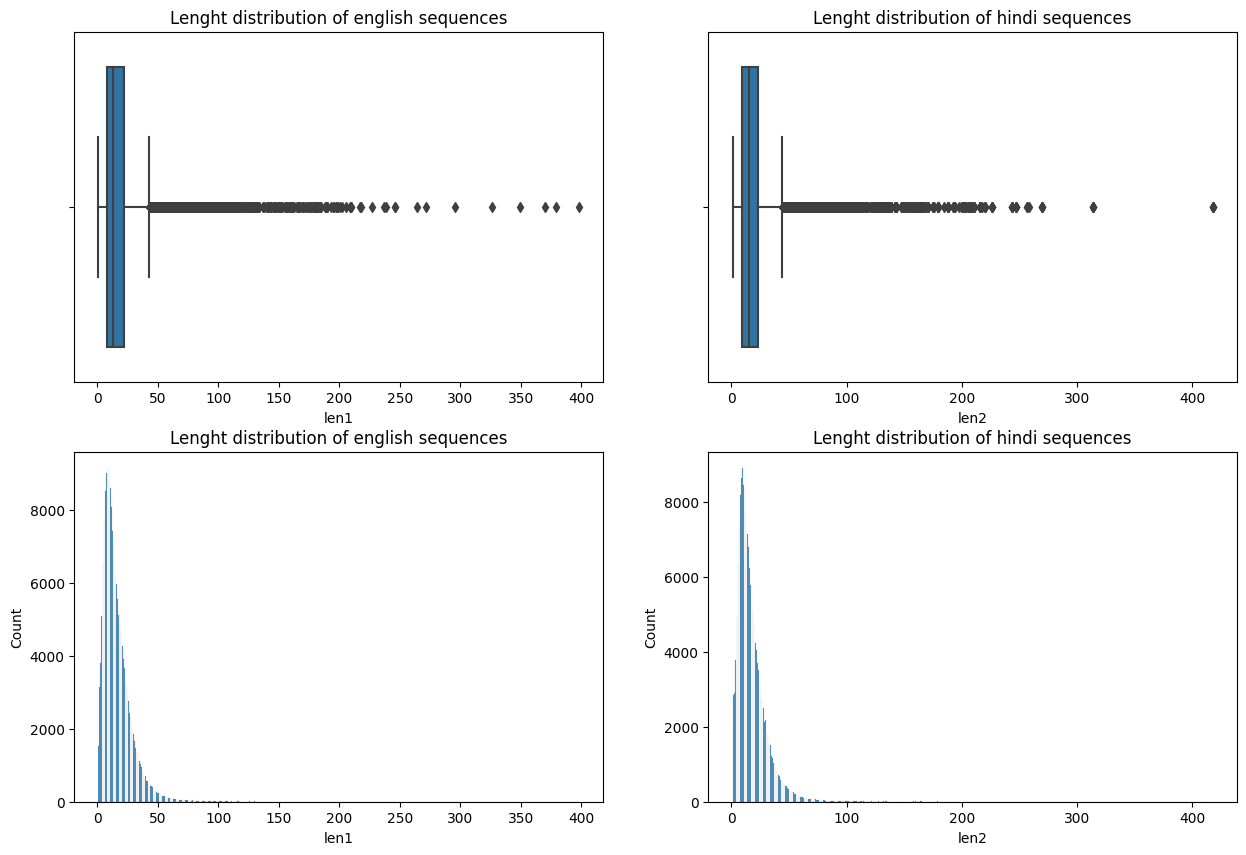

In [75]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.title("Lenght distribution of english sequences")
sns.boxplot(data=df, x='len1')

plt.subplot(2, 2, 2)
plt.title("Lenght distribution of hindi sequences")
sns.boxplot(data=df, x='len2')

plt.subplot(2, 2, 3)
plt.title("Lenght distribution of english sequences")
sns.histplot(data=df, x='len1')

plt.subplot(2, 2, 4)
plt.title("Lenght distribution of hindi sequences")
sns.histplot(data=df, x='len2')

plt.show()

In [76]:
def generate_wordCloud(sequence: (list, tuple, np.array), language: str, top: int = 30):
    sw = stopwords.words(language)
    tokens = word_tokenize(sequence)
    tokens = [word for word in tokens if word.isalpha() and word not in sw]
    
    freq = Counter(tokens)
    
    top_words = dict(freq.most_common(top))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
    
    plt.imshow(wordcloud)

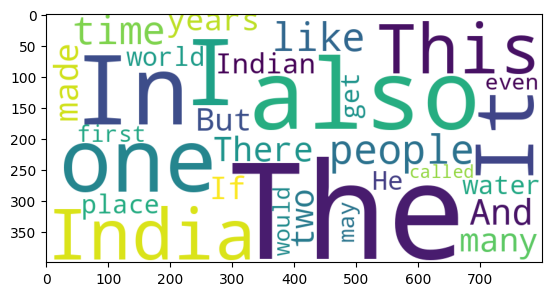

In [77]:
generate_wordCloud(" ".join(list(df.en.values)), 'english')

### Preprocessing

In [78]:
df.en = df.en.apply(lambda x : x.lower())

In [79]:
MAX_INPUT_LEN = 25
MAX_OUTPUT_LEN = 25

MIN_INPUT_LEN = 3
MIN_OUTPUT_LEN = 3

In [80]:
df = df[((df.len1 >= MIN_INPUT_LEN) & (df.len1 <= MAX_INPUT_LEN)) & ((df.len2 >= MIN_OUTPUT_LEN) & (df.len2 <= MAX_OUTPUT_LEN))]

In [81]:
df.shape

(130676, 4)

In [82]:
df.en = df.en.apply(lambda x : "SOS " + x)
df.hi = df.hi.apply(lambda x : "SOS " + x + " EOS")

In [83]:
en_tokenizer = Tokenizer(filters="!@#$%^&*()-_=+[]{}|;:'\",.<>/?`~")
en_tokenizer.fit_on_texts(df.en)
print(f"Number of unique words in English : {len(en_tokenizer.word_index)}")

hi_tokenizer = Tokenizer(filters="अआइईउऊऋएऐओऔंः।ऽऽ-–/\\")
hi_tokenizer.fit_on_texts(df.hi)
print(f"Number of unique words in Hindi : {len(hi_tokenizer.word_index)}")

Number of unique words in English : 56019
Number of unique words in Hindi : 63869


In [84]:
en_sequences = en_tokenizer.texts_to_sequences(df.en)
hi_sequences = hi_tokenizer.texts_to_sequences(df.hi)

In [85]:
pad_en_seq = pad_sequences(en_sequences, padding='post', maxlen = MAX_INPUT_LEN)
pad_hi_seq = pad_sequences(hi_sequences, padding='post', maxlen = MAX_OUTPUT_LEN)

In [86]:
VOCAB_SIZE_EN = len(en_tokenizer.word_index)
VOCAB_SIZE_HI = len(hi_tokenizer.word_index)

In [87]:
VOCAB_SIZE_EN, VOCAB_SIZE_HI

(56019, 63869)

In [112]:
EMBEDDING_DIM = 256
ENCODERS = 2
DECODERS = 2
ENCODER_HEADS = 4
DECODER_HEADS = 4
ENCODER_NODES = 1024
DECODER_NODES = 1024
BATCH_SIZE = 64
EPOCHS = 5

### Model

In [113]:
class PositionalEncoding(Layer):
    '''
    Positional encoding model

    Constructor takes the following:
    
    args
        - embedding_dim: the size of the embedding vector
        - seq_len: length of input sequence (default 100)

    Call takes the following:
    - input: the original word embedding (as batch of sentences)

    Call returns the following:
    - output: the word embedding with positional encoding (as batch of sentences)

    '''
    def __init__(self, embedding_dim, seq_len = 100):
        super(PositionalEncoding, self).__init__()

        self.seq_len = seq_len
        self.embedding_dim = embedding_dim


        pos = np.arange(0, seq_len).reshape(seq_len, 1)  # indexes of words

        embed_pos = np.arange(0, embedding_dim)  # indexes of embedding dimensions
        div_term = np.power(10000, 2 * (embed_pos // 2) / embedding_dim)  # division term

        self.positional_encoding = np.zeros((seq_len, embedding_dim))  # positional encoding matrix

        # for i in range(seq_len):
        #     for j in range(embedding_dim):
        #         if j % 2 == 0:
        #             self.positional_encoding[i, j] = np.sin(pos[i] / div_term[j])
        #         else:
        #             self.positional_encoding[i, j] = np.cos(pos[i] / div_term[j])


        self.positional_encoding[:, 0::2] = np.sin(pos / div_term[0::2])  # even indices
        self.positional_encoding[:, 1::2] = np.cos(pos / div_term[1::2])  # odd indices

        self.positional_encoding = tf.convert_to_tensor(self.positional_encoding)
        self.positional_encoding = tf.cast(self.positional_encoding, tf.float32)

        # positional_encoding.shape = (seq_len, embedding_dims)

    def call(self, input_batch):
        """
        args
            - input_batch: (batch_size, seq_len, embedding_dim)
            
        - output: (batch_size, seq_len, embedding_dim)
        """
        
        seq_len = tf.shape(input_batch)[1]
        pos = self.positional_encoding[:seq_len, :]
        
        return input_batch + tf.expand_dims(pos, axis = 0)


class MultipleHeadAttention(Layer):
    '''
    MultipleHeadAttention Model

    the constructor takes the following:
    args
        - embedding_dims = dimensions of embedding vector
        - num_heads = number of attention heads

    call functions takes following:
    args
        - q: input for query (batch_size, seq_len_q, embedding_dim)
        - k: input for key (batch_size, seq_len_k, embedding_dim)
        - v: input for value (batch_size, seq_len_v, embedding_dim)
        
    output
    - output: (batch_size, seq_len_q, d_model)
    '''

    def __init__(self, embedding_dim, num_heads):
        super(MultipleHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0, "Embedding dimensions must be divisible by number of heads"

        self.depth = embedding_dim // self.num_heads

        self.wq = [Dense(self.depth) for _ in range(num_heads)]
        self.wk = [Dense(self.depth) for _ in range(num_heads)]
        self.wv = [Dense(self.depth) for _ in range(num_heads)]

        self.dense = Dense(embedding_dim)

    def scaled_dot_product(self, q, k, v, mask = None):
        """
        Calculate the attention weights and apply them to the values.
        
        args
            - q: query vector (batch_size, seq_len_q, depth)
            - k: key vector (batch_size, seq_len_k, depth)
            - v: value vector (batch_size, seq_len_v, depth)
            (optional)
            - mask: (batch_size, 1, seq_len_q) or (batch_size, seq_len_q, seq_len_q)
            
        - output: attention value (batch_size, seq_len_q, depth)
        """

        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, seq_len_q, seq_len_k)



        dk = tf.cast(tf.shape(k)[-1], tf.float32)  # dimensions of embedding dim as float
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None: # for masking values like padding zero
            scaled_attention_logits += (mask * -1e9)
            
            
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # normalizing the values (batch_size, seq_len_q, seq_len_k)
        output = tf.matmul(attention_weights, v)  # (batch_size, seq_len_q, depth)
        
        return output, attention_weights
    

    def call(self, q, k, v, mask = None):
        '''
        args
            - q: (batch_size, seq_len_q, embedding_dim)
            - k: (batch_size, seq_len_k, embedding_dim)
            - v: (batch_size, seq_len_v, embedding_dim)
        '''
        batch_size = tf.shape(q)[0]

        q = [self.wq[i](q) for i in range(self.num_heads)]  # (num_heads, batch_size, seq_len_q, depth)
        k = [self.wk[i](k) for i in range(self.num_heads)]
        v = [self.wv[i](v) for i in range(self.num_heads)]


        attention_outputs = []
        
        for i in range(self.num_heads):
                
            attention_output, _ = self.scaled_dot_product(q[i], k[i], v[i], mask)
            attention_outputs.append(attention_output)

        # Concatenate the attention outputs
        scaled_attention = tf.concat(attention_outputs, axis=-1)  # (batch_size, seq_len_q, embedding_dim)

        # Final linear layer
        output = self.dense(scaled_attention)  # (batch_size, seq_len_q, embedding_dim)

        return output
    
class LayerNormalization(Layer):
    '''
    Layer normalization model

    Call takes the following:
    - input: the input to the layer normalization (batch_size, seq_len, embedding_dim)

    Call returns the following:
    - output: the normalized input
    '''
    def __init__(self, epsilon=1e-6):
        super(LayerNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        '''
        - input_shape: (batch_size, seq_len, embedding_dim)
        '''
        # Learnable gamma and beta parameters for scaling and shifting
        self.gamma = self.add_weight(shape=input_shape[-1:],
                                     initializer='ones',
                                     trainable=True,
                                     name='gamma')
        self.beta = self.add_weight(shape=input_shape[-1:],
                                    initializer='zeros',
                                    trainable=True,
                                    name='beta')

    def call(self, inputs):
        '''
        args
            - inputs: (batch_size, seq_len, embedding_dim)
        
        - output: (batch_size, seq_len, embedding_dim)
        '''
        # Compute the mean and variance of the inputs
        mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        variance = tf.reduce_mean(tf.square(inputs - mean), axis=-1, keepdims=True)

        # Normalize the inputs
        normalized_inputs = (inputs - mean) / tf.sqrt(variance + self.epsilon)

        # Scale and shift
        return self.gamma * normalized_inputs + self.beta


class Encoder(Layer):
    '''
    Encoder model

    The constructor takes the following:
    
    args
        - vocab_size: the size of the vocabulary
        - embedding_dim: the size of the embedding vector
        - num_heads: the number of heads in the multi-head attention
        - num_nodes: the number of nodes in the feed forward network
        - dropout_rate: the dropout rate

    The call method takes the following:
    - inputs_batch: the input to the encoder in form of batch

    The call method returns the following:
    - output: the output of the encoder
    '''
    
    def __init__(self, vocab_size, embedding_dim, num_heads, num_nodes, dropout_rate = 0.1):
        super(Encoder, self).__init__()


        # MultiHeadAttention
        self.multiHeadAttention = MultipleHeadAttention(embedding_dim, num_heads)

        # LayerNormalization
        self.layerNormalization1 = LayerNormalization()
        self.layerNormalization2 = LayerNormalization()
        

        # Fully Connected Layer
        self.feedForwardNetwork = Sequential([Dense(num_nodes, activation = 'relu'),
                                              Dense(embedding_dim)])

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)


    def call(self, input_batch, mask=None, training=False):
        """
        args
            - input_batch: input for encoder (batch_size, seq_len, embedding_dim)
            - mask: padding_mask for encoder (batch_size, 1, 1, seq_len)

        - output: (batch_size, seq_len, embedding_dim)
        """

        positionalEncoding = input_batch

        # multi head attention
        attention_output = self.multiHeadAttention(
            q = positionalEncoding,
            k = positionalEncoding,
            v = positionalEncoding,
            mask = mask
        )
        attention_output = self.dropout1(attention_output, training = training)
        attention_output += positionalEncoding
        attention_output = self.layerNormalization1(attention_output)
        

        # feed forward network
        feed_forward_output = self.feedForwardNetwork(attention_output)
        feed_forward_output = self.dropout2(feed_forward_output, training = training)
        feed_forward_output += attention_output
        output = self.layerNormalization2(feed_forward_output)
        

        return output
    

class Decoder(Layer):
    '''
    Decoder model

    The constructor takes the following:
    args
        - vocab_size: the size of the vocabulary
        - embedding_dim: the size of the embedding vector
        - num_heads: the number of heads in the multi-head attention
        - num_nodes: the number of nodes in the feed forward network
        - dropout_rate: the dropout rate

    The call method takes the following:
    - inputs_batch: the input to the Decoder in form of batch

    The call method returns the following:
    - output: the output of the Decoder
    '''

    def __init__(self, vocab_size, embedding_dim, num_heads, num_nodes, dropout_rate = 0.1):
        super(Decoder, self).__init__()


        self.maskMultiHeadAttention = MultipleHeadAttention(embedding_dim, num_heads)

        self.crossAttention = MultipleHeadAttention(embedding_dim, num_heads)

        # LayerNormalization
        self.layerNormalization1 = LayerNormalization()
        self.layerNormalization2 = LayerNormalization()
        self.layerNormalization3 = LayerNormalization()

        # Fully Connected Layer
        self.feedForwardNetwork = Sequential([Dense(num_nodes, activation = 'relu'),
                                              Dense(embedding_dim)])
        
        # DropOut Layer
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, input_batch, encoder_output, look_ahead_mask, padding_mask, training=False):
        """
        args
            - inputs_batch: input for decoder (batch_size, seq_len_dec, embedding_dim)
            - encoder_output: output generated by encoder (batch_size, seq_len_en, embedding_dim)
            - look_ahead_mask: mask for masked attention (batch_size, 1, seq_len_dec, seq_len_dec)
            - padding_mask: mask for padding (batch_size, 1, 1, seq_len_dec)
            - training: True while training
        
        - output: 
        """

        positionalEncoding = input_batch

        # Mask Multi Head Attention
        maskAttentionOutput = self.maskMultiHeadAttention(
            q = positionalEncoding,
            k = positionalEncoding,
            v = positionalEncoding,
            mask = look_ahead_mask
        )
        maskAttentionOutput = self.dropout1(maskAttentionOutput, training = training)
        maskAttentionOutput += positionalEncoding
        maskAttentionOutput = self.layerNormalization1(maskAttentionOutput)

        # Cross Attention output
        crossAttentionOutput = self.crossAttention(
            q = maskAttentionOutput,
            k = encoder_output,
            v = encoder_output,
            mask = padding_mask
        )
        crossAttentionOutput = self.dropout2(crossAttentionOutput, training = training)
        crossAttentionOutput += maskAttentionOutput
        crossAttentionOutput = self.layerNormalization2(crossAttentionOutput)

        # Feed Forward Network
        feed_forward_ouput = self.feedForwardNetwork(crossAttentionOutput)
        feed_forward_ouput = self.dropout3(feed_forward_ouput, training = training)
        feed_forward_ouput += crossAttentionOutput
        output = self.layerNormalization3(feed_forward_ouput)

        return output
    

class Transformer(Model):
    '''
    Transformer model

    Constructor takes the following:
    
    args
        - vocab_size_input: the size of the vocabulary (inputs)
        - vocab_size_output: the size of the vocabulary (outputs)
        - embedding_dim: the size of the embedding vector
        - num_heads_encoder: the number of attention heads in encoder
        - num_heads_decoder: the number of attention heads in decoder
        - num_encoder_layers: the number of encoder layers
        - num_decoder_layers: the number of decoder layers
        - num_nodes_encoder: the number of nodes in the feed-forward network of encoder
        - num_nodes_decoder: the number of nodes in the feed-forward network of decoder
        - dropout_rate: the dropout rate

    Call takes the following:
    
    args:
        - encoder_input: input to the encoder
        - decoder_input: input to the decoder
        - training: boolean indicating training model


    Call returns the following:
    
    - output: the output of the transformer model
    '''

    def __init__(self, vocab_size_input, vocab_size_output, embedding_dim, num_heads_encoder, num_heads_decoder, num_encoder_layers, num_decoder_layers, num_nodes_encoder, num_nodes_decoder, dropout_rate=0.1):
        super(Transformer, self).__init__()
        
        self.embedding_encoder = Embedding(vocab_size_input, embedding_dim)
        self.embedding_decoder = Embedding(vocab_size_output, embedding_dim)
        
        self.positional_encoding = PositionalEncoding(embedding_dim)

        self.encoder_layers = [
            Encoder(
                vocab_size = vocab_size_input,
                embedding_dim = embedding_dim,
                num_heads = num_heads_encoder,
                num_nodes = num_nodes_encoder,
                dropout_rate = dropout_rate
            )
            for _ in range(num_encoder_layers)
        ]

        self.decoder_layers = [
            Decoder(
                vocab_size = vocab_size_output,
                embedding_dim = embedding_dim,
                num_heads = num_heads_decoder,
                num_nodes = num_nodes_decoder,
                dropout_rate = dropout_rate
            )
            for _ in range(num_decoder_layers)
        ]

        self.final_layer = Dense(vocab_size_output)  # Final linear layer to project decoder output to vocab size
        


    def call(self, encoder_input, decoder_input, enc_padding_mask, combined_mask, dec_padding_mask, training=False):
        """
        args
            - encoder_input: (batch_size, in_seq_len)
            - decoder_input: (batch_size, out_seq_len)
            - enc_padding_mask: (batch_size, 1, 1, in_seq_len)
            - combined_mask: (batch_size, 1, out_seq_len, out_seq_len)
            - dec_padding_mask: (batch_size, 1, 1, out_seq_len)
            - Training: True while training
            
        - output: (batch_size, seq_len, vocab_size)
        """
        
        encoder_embedding = self.embedding_encoder(encoder_input)  # (batch_size, in_seq_len, embedding_dim)
        encoder_positional_embedding = self.positional_encoding(encoder_embedding)  # (batch_size, in_seq_len, embedding_dim)
        
        # Pass through each encoder layer
        encoder_output = encoder_positional_embedding
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output, enc_padding_mask, training = training)
            
        
        decoder_embedding = self.embedding_decoder(decoder_input)  # (batch_size, out_seq_len, embedding_dim)
        decoder_positional_embedding = self.positional_encoding(decoder_embedding)  # (batch_size, out_seq_len, embedding_dim)
        
        # Pass through each decoder layer
        decoder_output = decoder_positional_embedding
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, combined_mask, dec_padding_mask, training=training)
            
            
        # Pass through the final linear layer to get the logits for each token in the sequence
        output = self.final_layer(decoder_output)

        return output

In [114]:
# Create an instance of the Transformer model
transformer = Transformer(
    VOCAB_SIZE_EN,
    VOCAB_SIZE_HI,
    EMBEDDING_DIM,
    ENCODER_HEADS,
    DECODER_HEADS,
    ENCODERS,
    DECODERS,
    ENCODER_NODES,
    DECODER_NODES
)

In [115]:
class CreateMask:
    
    def create_padding_mask(self, seq):
        """
        Creates a padding mask for a given sequence.

        Args:
            seq (tensor): A tensor of shape (batch_size, seq_len) containing the sequence.

        Returns:
            A tensor of shape (batch_size, 1, seq_len) containing a mask that is 1 where the sequence is padded, and 0 otherwise.
        """
        # Convert the sequence to a boolean tensor where True indicates a pad token (value 0).
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # Add an extra dimension to the mask to add the padding to the attention logits.
        return seq[:, tf.newaxis, :]
    
    def create_look_ahead_mask(self, size):
        """
        Creates a look-ahead mask used during training the decoder of a transformer.

        Args:
            size (int): The size of the mask.

        Returns:
            tf.Tensor: A lower triangular matrix of shape (size, size) with ones on the diagonal
                and zeros below the diagonal.
        """
        # create a matrix with ones on the diagonal and zeros below the diagonal
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

        return mask
    

    def create_masks(self, inputs, targets):
        """
        Creates masks for the input sequence and target sequence.

        Args:
            inputs: Input sequence tensor.
            targets: Target sequence tensor.

        Returns:
            A tuple of three masks: the encoder padding mask, the combined mask used in the first attention block, 
            and the decoder padding mask used in the second attention block.
        """

        # Create the encoder padding mask.
        enc_padding_mask = self.create_padding_mask(inputs)

        # Create the decoder padding mask.
        # this passed to decoder crossAttentionLayer so it should be calculated on encoder_output (same as encoder_input)
        dec_padding_mask = self.create_padding_mask(inputs)
        
        dec_target_padding_mask = self.create_padding_mask(targets)
        
        # Create the look ahead mask for the first attention block.
        # It is used to pad and mask future tokens in the tokens received by the decoder.
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(targets)[1])


        # Combine the look ahead mask and decoder target padding mask for the first attention block.
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask


In [116]:
class Metrices:
    
    def __init__(self):
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    
    def loss_function(self, true_value, predicted):
        
        """
        Calculate the loss value for a given target sequence.

        Args:
            true_values: The true target sequence.
            predictions: The predicted target sequence.

        Returns:
            float: The loss value for the given target sequence.
        """
        # Create a mask to exclude the padding tokens
        mask = tf.math.logical_not(tf.math.equal(true_value, 0))

        # Compute the loss value using the loss object
        loss_ = self.loss_object(true_value, predicted)

        # Apply the mask to exclude the padding tokens (makes padding loss zero)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        # Calculate the mean loss value (total_loss / number_of_losses)
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

    
    def accuracy_function(self, true_value, predicted):
        """
        Calculate the accuracy for a given target sequence.

        Args:
            true_values (tf.Tensor): The true target sequence.
            predictions (tf.Tensor): The predicted target sequence.

        Returns:
            float: The accuracy value for the given target sequence.
        """

        # Compute the accuracies using the true and predicted target sequences
        accuracies = tf.equal(true_values, tf.argmax(predicted, axis=-1))

        # Create a mask to exclude the padding tokens
        mask = tf.math.logical_not(tf.math.equal(true_values, 0))

        # Apply the mask to exclude the padding tokens from the accuracies
        accuracies = tf.math.logical_and(mask, accuracies)
        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)

        # Calculate the mean accuracy value
        return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)



In [117]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    """
    A custom learning rate schedule that uses a combination of
    a square root inverse decay and a warmup schedule.

    Args:
        embedding_dim (int): The dimension of the embedding.
        warmup_steps (int): The number of steps used for warmup.

    Returns:
        float: The learning rate value at a given step.
    """

    def __init__(self, embedding_dim, warmup_steps=1000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        """
        Compute the learning rate value for a given step using
        a combination of square root inverse decay and warmup.

        Args:
            step (int): The current step number.

        Returns:
            float: The learning rate value at the current step.
        """
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

### Training

In [118]:
class Train:
    
    def __init__(self, batch_size, max_input_len, max_output_len, transformer,
                   optimizer = keras.optimizers.Adam):
        
        # training signature list containing specifications (shape, dtype) of all the inputs sequences passed to training
        self.train_signature = [
            tf.TensorSpec((batch_size, max_input_len), dtype = tf.float32),
            tf.TensorSpec((batch_size, max_output_len), dtype = tf.float32)
        ]

        # Define the training metrics
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
        
        # Store the optimizer class
        self.optimizer_class = optimizer
        
        # Initialize the optimizer with default parameters
        self.optimizer = self.optimizer_class()
        
        self.transformer = transformer
        
        # Wrap the train_step function with tf.function and input signature
        self.train_step = tf.function(self.train_step, input_signature=self.train_signature)

        
    def set_optimizer(self, learning_rate=0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9):
        """
        Set a custom optimizer with specific parameters.

        Args:
            learning_rate (float): The learning rate for the optimizer.
            beta_1 (float): The exponential decay rate for the first moment estimates.
            beta_2 (float): The exponential decay rate for the second-moment estimates.
            epsilon (float): A small constant for numerical stability.
        """
        self.optimizer = self.optimizer_class(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        
        
#     @tf.function(input_signature=self.train_signature)
    def train_step(self, input_seq, output_seq):
        """
        Function to perform a single training step.

        Args:
        input_seq (tf.Tensor): The input tensor for the encoder.
        output_seq (tf.Tensor): The target tensor for the decoder.

        Returns:
        None.
        """

        # remove last word from each sequence of input (since we need to predict this word at last and no further prediction is done)
        decoder_input = output_seq[:, :-1]


        # remove first word from each sequence of expected output (since we don't predict the first word)
        expected_output = output_seq[:, 1:]

        mask = CreateMask()
        enc_padding_mask, combined_mask, dec_padding_mask = mask.create_masks(input_seq, decoder_input)

        evaluate = Metrices()

        with tf.GradientTape() as tape:

            prediction = self.transformer(input_seq,
                                     decoder_input,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask,
                                     training=True)

            loss = evaluate.loss_function(expected_output, prediction)


        gradients = tape.gradient(loss, transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))


        # Update the training loss and accuracy metrics
        self.train_loss(loss)
        self.train_accuracy(expected_output, prediction)

In [119]:
for epoch in tqdm(range(EPOCHS), desc = 'Epochs'):  # iterate epochs
    
    train = Train(
        batch_size = BATCH_SIZE,
        max_input_len = MAX_INPUT_LEN,
        max_output_len = MAX_OUTPUT_LEN,
        transformer = transformer
    )
    train.set_optimizer(learning_rate = CustomSchedule(EMBEDDING_DIM))
    
    # Reset the metrics at the start of each epoch
    train.train_loss.reset_state()
    train.train_accuracy.reset_state()
    
    # starting index of each batch
    batch_start_index = 0
    
    # run number of batches
    for i in tqdm(range(len(pad_en_seq) // BATCH_SIZE), desc = 'Batch', leave = True):
        # slice the sequences in batches and convert them to tensor of dtype float32
        input_seq = tf.convert_to_tensor(pad_en_seq[batch_start_index : batch_start_index + BATCH_SIZE], dtype = tf.float32)
        output_seq = tf.convert_to_tensor(pad_hi_seq[batch_start_index : batch_start_index + BATCH_SIZE], dtype = tf.float32)
        
        # train for each batch
        train.train_step(input_seq, output_seq)
        
        # update batch starting index
        batch_start_index += BATCH_SIZE
        
    # print result
    print(f"Epoch : {epoch}, loss : {train.train_loss.result().numpy()}, accuracy : {train.train_accuracy.result().numpy()}")

Epochs:  20%|██        | 1/5 [10:24<41:36, 624.08s/it]

Epoch : 0, loss : 9.490900039672852, accuracy : 0.3912028670310974



Epochs:  40%|████      | 2/5 [20:41<30:59, 619.99s/it]

Epoch : 1, loss : 9.546076774597168, accuracy : 0.4081369638442993



Epochs:  60%|██████    | 3/5 [31:02<20:40, 620.37s/it]

Epoch : 2, loss : 9.546076774597168, accuracy : 0.4081369638442993



Epochs:  80%|████████  | 4/5 [41:18<10:18, 618.96s/it]

Epoch : 3, loss : 9.546076774597168, accuracy : 0.4081369638442993



Epochs: 100%|██████████| 5/5 [51:40<00:00, 620.04s/it]

Epoch : 4, loss : 9.546076774597168, accuracy : 0.4081369638442993


### Evaluate

In [123]:
def translate_helper(sentence):
    """
    Evaluate function that generates a translated sentence from the given input sentence.

    Args:
        - sentence (list): The input sentence in the source language.

    Returns:
    A tensor representing the translated sentence.
    """
    
    # Preprocess the input sentence
    sentence = 'SOS ' + sentence[0] # Add start and end of sentence markers
    sentence = [sentence] # Convert sentence to list because of TensorFlow's tokenizer
    
    # Vectorize and pad the sentence
    sentence = en_tokenizer.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=MAX_INPUT_LEN, padding='post', truncating='post')
    input_ = tf.convert_to_tensor(np.array(sentence),dtype=tf.float32) # Convert input to tensor
    
    # Tokenize the start of the decoder input and convert it to a tensor
    decoder_input = hi_tokenizer.texts_to_sequences(['SOS'])
    decoder_input = pad_sequences(decoder_input, maxlen=MAX_OUTPUT_LEN, padding='post')
    decoder_input = tf.convert_to_tensor(np.array(decoder_input), dtype=tf.float32)
    
    mask = CreateMask()
    # Generate the translated sentence
    for i in range(MAX_OUTPUT_LEN):
        # Create masks for the encoder, decoder, and combined
        enc_padding_mask, combined_mask, dec_padding_mask = mask.create_masks(input_, decoder_input)
        # Generate predictions for the current input sequence
        predictions = transformer(input_, decoder_input,enc_padding_mask,combined_mask, dec_padding_mask, training = False)
        # Select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        # Get the predicted word ID by taking the argmax of the predictions
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.float32)
        
        # If the predicted ID is equal to the end token, return the decoder input
        if predicted_id == hi_tokenizer.texts_to_sequences(['eos']):
            return tf.squeeze(decoder_input, axis=0)
        
        # Concatenate the predicted ID to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
    
    # Return the translated sentence
    return tf.squeeze(decoder_input, axis=0)

In [126]:
def translate(sentence):
    """
    Translate function that generates a translation for the given input sentence.

    Args:
        - sentence (str): The input sentence in the source language.

    Returns:
    None.
    """
    
    # Convert sentence to list because our evaluate function requires lists
    sentence = [sentence]
    
    # Print the input sentence
    print(f'Input sentence: {sentence[0]}')
    print()
    
    # Generate the translated sentence
#     print(translate_helper(sentence))
    result = (translate_helper(sentence)).numpy().tolist()
    print(result)
    
    # Convert the result tensor to a list of IDs and remove start and end of sentence markers
    predicted_ids = [i for i in result if i != hi_tokenizer.texts_to_sequences(['SOS'])[0][0]
                     and i != hi_tokenizer.texts_to_sequences(['EOS'])[0][0]]
    
    # Convert the predicted IDs to a list of words
    predicted_sentence = hi_tokenizer.sequences_to_texts([predicted_ids])
    
    # Print the predicted translation
    print(f'Translation: {predicted_sentence[0]}')

In [ ]:
translate("hi")